In [2]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import scipy.misc, os, csv, random, math
from subprocess import check_output
import matplotlib.pyplot as plt

# Parameters

In [3]:
# AC
#trainImagePath='C:/Users/ANTHO/Desktop/TestTensorFlow/KAGGLE/Dataset/imgpp/'
#labelsPath = 'C:/Users/ANTHO/Desktop/TestTensorFlow/KAGGLE/Dataset/GT/'

# VSP
#trainImagePath='/Users/valurpalmarsson/Documents/DeepLearning/imgpp/'
#labelsPath = '/Users/valurpalmarsson/Documents/DeepLearning/GT/'

trainImagePath='./Dataset/imgpp/'
labelsPath = './Dataset/GT/'

mainPath='./Measure'

epochs=5
batchSize=10
learningRate=1e-4
numImg = 200 # Number of images to Load
shuffleData = False # Shuffle data

# Size of each subset as precentage of entire dataset
trainSize=0.5
valSize=0.25
testSize=0.25

In [4]:
path = mainPath
i=0
while os.path.exists(path):
    path = mainPath+str(i)
    i=i+1
    print(path)

os.makedirs(path)
os.makedirs(path+'/Tensorboard')
os.makedirs(path+'/SaveModel')
os.makedirs(path+'/Results')


./Measure0
./Measure1


# Extract the images & Labels

In [5]:
#Extract all the file in the folder
fileNames = os.listdir(trainImagePath)

# select a subset of files
fileNames = fileNames[:numImg]


In [6]:
#Extract all the image flatten and write them in an array
imgs=[] # Init image list
labels=[] # 
for fileName in fileNames: 
    
    # Load images
    img = scipy.misc.imread(trainImagePath+fileName, False,'RGB')     
    img = img.ravel()#Flatten the image
    imgs.append(img)
    
    # Load labels
    labelName = fileName.partition('pp')[0]+'GT.csv'
    with open(labelsPath+labelName, 'r') as f:#Read the file
        reader = csv.reader(f)
        label= np.asarray(list(reader), dtype=float)#Extract the value in an array
        label = label.ravel()#flatten
        labels.append(label)#Add to the list
        
imgs=np.matrix(imgs, dtype=float)/255
labels = np.matrix(labels, dtype=float)#Convert to a matrix
    
#Size(nbImage, nbPixel)
print(imgs.shape)
print(len(imgs))


(200, 196608)
200


# Select size of train and test

In [7]:
# Creates train, validate and test subsets from the loaded images
# Can shuffle the images by using the boolean input argument shuffle
def createDatasets(imgs,labels,trainSize,valSize,testSize,shuffle):

    # Get number of images
    numImg = len(imgs) 
    
    # Indexes used to split the entire dataset into subsets
    indx1 = int(numImg*trainSize)
    indx2 = int(numImg*(trainSize+valSize))
    
    if shuffle:
        # Shuffle images to a random order, (shuffles imgs and labels in the same random order)
        combined = list(zip(imgs, labels))
        random.shuffle(combined)
        imgs[:], labels[:] = zip(*combined)

    # Training subset
    imgsTrain = imgs[0:indx1]
    labelsHotTrain = labels[0:indx1]

    # Validation subset
    imgsValidate = imgs[indx1:indx2]
    labelsHotValidate = labels[indx1:indx2]

    # Test subset
    imgsTest = imgs[indx2:]
    labelsHotTest = labels[indx2:]
    
    # Return the subsets as well as the corresponding ground-truth
    return imgsTrain,labelsHotTrain,imgsValidate,labelsHotValidate,imgsTest,labelsHotTest

# Convolutional Neural Network

In [8]:
## PARAMETERS ##
tensorBoard=True      #Save a summary?
saveVariable=False     #Save the variabe?
#retrieveSavedVariable=True #Retrieve saved variable?

# Split dataset to subsets
imgsTrain,labelsHotTrain,imgsValidate,labelsHotValidate,imgsTest,labelsHotTest = createDatasets(imgs,labels,trainSize,valSize,testSize,shuffleData)

In [9]:
#Function

def evaluateNetwork(v_xs, v_ys):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs}) # Forward pass using v_xs as input to network
    y_pre = tf.cast(y_pre, tf.float32) # Force float32 
    result = tf.reduce_sum(y_pre) # Integrate over density map to get estimated sea lion count
    return result

# Calculate mean absolute error (MAE) and mean square error (MSE) for evaluation
def compute_accuracy(v_xs, v_ys):
    global prediction
    y_label = tf.reshape(v_ys, [-1, 43, 43, 1])
    y_label = tf.cast(y_label, tf.float32)
    y_pre = sess.run(prediction, feed_dict={xs: v_xs})
    y_pre = tf.cast(y_pre, tf.float32)#Force float32
    #correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1))
    diff = tf.subtract(tf.reduce_sum(y_label,[1,2]),tf.reduce_sum(y_pre,[1,2]))
    accuracyMAE = tf.cast(tf.reduce_mean(tf.abs(diff)),tf.float32)
    accuracyMSE = tf.cast(tf.sqrt(tf.reduce_mean(tf.square(diff))),tf.float32)
    MAE = sess.run(accuracyMAE, feed_dict={xs: v_xs, ys: v_ys})
    MSE = sess.run(accuracyMSE, feed_dict={xs: v_xs, ys: v_ys})
    
    return MAE,MSE

def weight_variable(shape, nameIn):
    initial = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(initial, name=nameIn)

def bias_variable(shape, nameIn):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=nameIn)

def conv2d(x, W):
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def max_pool_3x3(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,3,3,1], strides=[1,3,3,1], padding='SAME')

In [10]:
## Architecture

## Input layer ##
with tf.name_scope("Input") as scope:
    # define placeholder for inputs to network
    xs = tf.placeholder(tf.float32, [None, imgs.shape[1]])   # 256x256x3
    ys = tf.placeholder(tf.float32, [None, labels.shape[1]]) #43x43 
    x_image = tf.reshape(xs, [-1, 256, 256, 3])#[batch, in_depth, in_height, in_width, in_channels].
    y_label = tf.reshape(ys, [-1, 43, 43, 1])
    #print(x_image.shape)  # [n_samples, 28,28,1]
    
## conv1 layer ##
## maxpooling 2x2 ##
#20x (7x7)
patch=7
sizeIn=3
sizeOut=20
with tf.name_scope("Conv1") as scope:
    W_conv1 = weight_variable([patch,patch, sizeIn,sizeOut], "W_conv1")
    b_conv1 = bias_variable([sizeOut], "b_conv1")
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1) #Maxpooling 2x2, output size= inout size/2
    # Add summary ops to collect data
    w_h_conv1 = tf.summary.histogram("weightsConv1", W_conv1)
    b_h_conv1 = tf.summary.histogram("biasesConv1", b_conv1)
    
## conv2 layer ##
## maxpooling 3x3 ##
#40x (5x5)
patch=5
sizeIn=sizeOut #From previous ConvNet
sizeOut=40
with tf.name_scope("Conv2") as scope:
    W_conv2 = weight_variable([patch,patch, sizeIn,sizeOut],"W_conv2")
    b_conv2 = bias_variable([sizeOut],"b_conv2")
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_3x3(h_conv2) #Maxpooling 3x3, output size= inout size/3
    # Add summary ops to collect data
    w_h_conv2 = tf.summary.histogram("weightsConv2", W_conv2)
    b_h_conv2 = tf.summary.histogram("biasesConv2", b_conv2)
    
## conv3 layer ##
#20x (5x5)
patch=5
sizeIn=sizeOut #From previous ConvNet
sizeOut=20
with tf.name_scope("Conv3") as scope:
    W_conv3 = weight_variable([patch,patch, sizeIn,sizeOut],"W_conv3")
    b_conv3 = bias_variable([sizeOut],"b_conv3")
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    # Add summary ops to collect data
    w_h_conv3 = tf.summary.histogram("weightsConv3", W_conv3)
    b_h_conv3 = tf.summary.histogram("biasesConv3", b_conv3)
    
## conv4 layer ##
#10x (5x5)
patch=5
sizeIn=sizeOut #From previous ConvNet
sizeOut=10
with tf.name_scope("Conv4") as scope:
    W_conv4 = weight_variable([patch,patch, sizeIn,sizeOut],"W_conv4")
    b_conv4 = bias_variable([sizeOut],"b_conv4")
    h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4) + b_conv4)
    # Add summary ops to collect data
    w_h_conv4 = tf.summary.histogram("weightsConv4", W_conv4)
    b_h_conv4 = tf.summary.histogram("biasesConv4", b_conv4)
    
## conv5 layer ##
#1x (1x1)
patch=1
sizeIn=sizeOut #From previous ConvNet
sizeOut=1
with tf.name_scope("Conv5") as scope:
    W_conv5 = weight_variable([patch,patch, sizeIn,sizeOut], "W_conv5")
    b_conv5 = bias_variable([sizeOut], "b_conv5")
    h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5) + b_conv5)
    #h_conv5 = conv2d(h_conv4, W_conv5) + b_conv5
    # Add summary ops to collect data
    w_h_conv5 = tf.summary.histogram("weightsConv5", W_conv5)
    b_h_conv5 = tf.summary.histogram("biasesConv5", b_conv5)
    
   
 ## Prediction ##
with tf.name_scope("prediction") as scope:
    prediction = h_conv5
    #img_prediction = tf.summary.image("densitymap", prediction)


## Loss function ##
# the error between prediction and real data
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction),reduction_indices=[1]))# loss
with tf.name_scope("loss") as scope:
    loss = tf.reduce_mean(tf.square(tf.reduce_max(tf.subtract(prediction,y_label),[1,2])))
    #cross_entropy = tf.reshape(tf.reduce_sum(tf.square((tf.subtract(prediction, y_label))),0),[-1])#Euclidean distance
    tf.summary.scalar("loss", loss)
    
with tf.name_scope("train") as scope:
    train_step = tf.train.AdamOptimizer(learningRate).minimize(loss)
    #train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    


In [13]:
## INITIALISATION ##
if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
    init = tf.initialize_all_variables()
else:
    init = tf.global_variables_initializer()

    
## TENSOR BOARD ##
if tensorBoard:
    # Merge all summaries into a single operator
    merged_summary_op = tf.summary.merge_all() 

with tf.Session() as sess:
    sess.run(init)
    
    ### SAVE DATA ###
    if saveVariable:
        saver = tf.train.Saver()
 
    ### TENSORBOARD ###
    if tensorBoard:
        # Folder where the data are saved
        summary_writer = tf.summary.FileWriter(path+'/TensorBoard/', sess.graph)


    if int(len(imgs)) < batchSize:#If there are less data than the batch size
        nbBatch=1
    else:
        nbBatch=int((len(imgsTrain))/batchSize)
    
    # Init variables 
    trainMAE =  [0 for x in range(epochs)]
    validateMAE =  [0 for x in range(epochs)]
    trainMSE =  [0 for x in range(epochs)]
    validateMSE =  [0 for x in range(epochs)]
    
    #print(compute_accuracy(imgsTest,labelsHotTest))

    #print(compute_accuracy(imgsTest, labelsHotTest))
    for epoch in range(epochs):#Go through all the epochs
        for batchNum in range(nbBatch):#Go through all the batches
            #print(batchNum)
            if batchSize==1:
                batch_xs = imgsTrain[batchNum*batchSize]
                batch_ys = labelsHotTrain[batchNum*batchSize]
            else:
                batch_xs = imgsTrain[batchNum*batchSize:(batchNum*batchSize+(batchSize))]
                batch_ys = labelsHotTrain[batchNum*batchSize:(batchNum*batchSize+(batchSize))]
                #print(len(batch_xs))
            
            sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys})
        
        print('Epoch: ',epoch+1)
        
        trainMAE[epoch],trainMSE[epoch] = compute_accuracy(imgsTrain, labelsHotTrain)
        validateMAE[epoch],validateMSE[epoch] = compute_accuracy(imgsValidate, labelsHotValidate)
        
        print('Training MAE and MSE: ',trainMAE[epoch],trainMSE[epoch])
        print('Validation MAE and MSE: ',validateMAE[epoch],validateMSE[epoch])
        
        ### TENSORBOARD ###
        if tensorBoard:
            summary_str = sess.run(merged_summary_op, feed_dict={xs: batch_xs, ys: batch_ys})
            summary_writer.add_summary(summary_str, epoch)
        ### SAVE DATA ###
        if epoch%1==0:
            if saveVariable:
                saver.save(sess, path+'/SaveModel/cnnSave', global_step=epoch)
    testMAE, testMSE = compute_accuracy(imgsTest, labelsHotTest)       
    print('Test MAE and MSE: ',testMAE,testMSE)
    
    #Save the MAE and MSE of each epoch
    np.savetxt(path+"/Results/EpochMAEMSE.csv", np.transpose([trainMAE, trainMSE, validateMAE, validateMSE]), delimiter=",")
    np.savetxt(path+"/Results/TESTMAEMSE.csv", np.transpose([testMAE, testMSE]), delimiter=",")



Epoch:  1
Training MAE and MSE:  20.8176 25.1859
Validation MAE and MSE:  17.3958 18.5714
Epoch:  2
Training MAE and MSE:  8.65323 23.9099
Validation MAE and MSE:  3.64532 7.85429
Epoch:  3
Training MAE and MSE:  8.59882 24.0303
Validation MAE and MSE:  3.51879 7.97856
Epoch:  4
Training MAE and MSE:  8.59993 24.041
Validation MAE and MSE:  3.52031 7.98891
Epoch:  5
Training MAE and MSE:  8.60016 24.0432
Validation MAE and MSE:  3.52 7.98999
Test MAE and MSE:  2.35975 6.02317


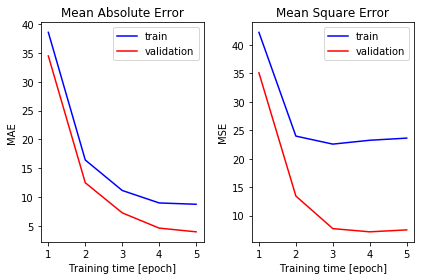

In [12]:
# Plot MAE and MSE during training

plt.subplot(121) # MAE
plt.plot(np.linspace(1,epochs,epochs),trainMAE,'b',label='train')
plt.plot(np.linspace(1,epochs,epochs),validateMAE,'r',label='validation')
plt.xlabel('Training time [epoch]')
plt.ylabel('MAE')
plt.legend(['train','validation'])
plt.title('Mean Absolute Error')

plt.subplot(122) # MSE
plt.plot(np.linspace(1,epochs,epochs),trainMSE,'b',label='train')
plt.plot(np.linspace(1,epochs,epochs),validateMSE,'r',label='validation')
plt.xlabel('Training time [epoch]')
plt.ylabel('MSE')
plt.legend(['train','validation'])
plt.title('Mean Square Error')
plt.tight_layout()
plt.savefig(path+'/Results/graphs.png')
plt.show()
